In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
#from lib import RadioUNet_modules3, RadioUNet_loaders2
from lib import loaders, modules

## Dataset Loader, RadioUNetc threshold=0.2

In [3]:
import torch
from torch.utils.data import DataLoader, RandomSampler
Radio_train = loaders.RadioUNet_s(phase="train",fix_samples=240, carsSimul="no", carsInput="no")
Radio_val = loaders.RadioUNet_s(phase="val",fix_samples=240, carsSimul="no", carsInput="no")
Radio_test = loaders.RadioUNet_s(phase="test",fix_samples=240, carsSimul="no", carsInput="no")

# image_datasets = {
#     'train': Radio_train, 'val': Radio_val
# }

# batch_size = 30

# dataloaders = {
#     'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
#     'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
# }

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 120

# 创建 generator 并确保它在 CUDA 设备上
generator = torch.Generator(device='cuda')

# 创建 RandomSampler 并传递 generator
train_sampler = RandomSampler(Radio_train, generator=generator)
val_sampler = RandomSampler(Radio_val, generator=generator)

# 创建 DataLoader 并传递 RandomSampler
dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, sampler=train_sampler, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, sampler=val_sampler, num_workers=1)
}


## Test Sample Image

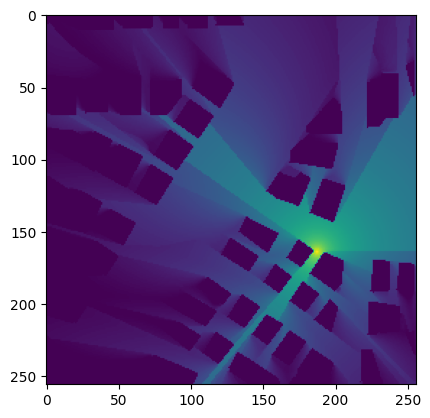

In [4]:
i=1000
image_build_ant, image_gain = Radio_train[i]
plt.imshow(image_gain[0])

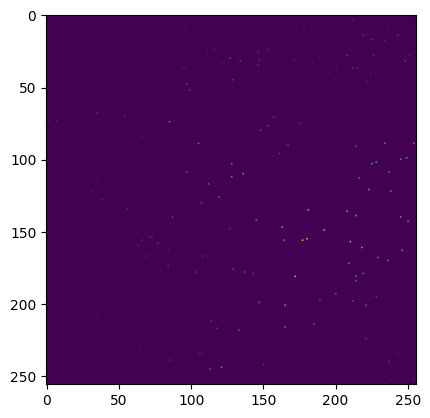

In [5]:
i=1000
image_build_ant, image_gain = Radio_train[i]
plt.imshow(image_build_ant[1])

## Load Model and Summary

In [6]:
# from torchsummary import summary

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.enabled
model =modules.RadioWNet(inputs=2, phase="firstU")
model.cuda()
# summary(model, input_size=(4, 256,256))

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Training Loop

In [7]:
#Adapted from https://github.com/usuyama/pytorch-unet

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss_dense(pred, target, metrics):
    criterion = nn.MSELoss()
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def calc_loss_sparse(pred, target, samples, metrics, num_samples):
    criterion = nn.MSELoss()
    loss = criterion(samples*pred, samples*target)*(256**2)/num_samples
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs1 = []
    outputs2 = []
    for k in metrics.keys():
        outputs1.append("{}: {:4f}".format(k, metrics[k] / (epoch_samples*256**2)))

    print("{}: {}".format(phase, ", ".join(outputs1)))

def train_model(model, optimizer, scheduler, num_epochs=50, WNetPhase="firstU", targetType="dense", num_samples=300):
    # WNetPhase: traine first U and freez second ("firstU"), or vice verse ("secondU").
    # targetType: train against dense images ("dense") or sparse measurements ("sparse")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("learning rate", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            if targetType=="dense":
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_dense(outputs1, targets, metrics)
                        else:
                            loss = calc_loss_dense(outputs2, targets, metrics)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)
            elif targetType=="sparse":
                for inputs, targets, samples in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    samples = samples.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_sparse(outputs1, targets, samples, metrics, num_samples)
                        else:
                            loss = calc_loss_sparse(outputs2, targets, samples, metrics, num_samples)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training First UNet


In [8]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler)

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.015202
val: loss: 0.008584
saving best model
2m 54s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.005740
val: loss: 0.003456
saving best model
2m 55s
Epoch 2/49
----------
learning rate 0.0001
train: loss: 0.003116
val: loss: 0.002670
saving best model
2m 54s
Epoch 3/49
----------
learning rate 0.0001
train: loss: 0.002639
val: loss: 0.002430
saving best model
2m 55s
Epoch 4/49
----------
learning rate 0.0001
train: loss: 0.002351
val: loss: 0.002140
saving best model
2m 54s
Epoch 5/49
----------
learning rate 0.0001
train: loss: 0.002135
val: loss: 0.001920
saving best model
2m 55s
Epoch 6/49
----------
learning rate 0.0001
train: loss: 0.001940
val: loss: 0.001770
saving best model
2m 55s
Epoch 7/49
----------
learning rate 0.0001
train: loss: 0.001776
val: loss: 0.001646
saving best model
2m 54s
Epoch 8/49
----------
learning rate 0.0001
train: loss: 0.001703
val: loss: 0.001563
saving best model
2m 54s
Epo

## Create Directory For Saving the Model and Examples

In [9]:
import os
try: 
    os.mkdir('RadioWNet_s_DPMcars_carInput_Thr2') 
except OSError as error: 
    print(error) 

[Errno 17] File exists: 'RadioWNet_s_DPMcars_carInput_Thr2'


## Save First U Model For Inference

In [10]:
torch.save(model.state_dict(), 'RadioWNet_s_DPMcars_carInput_Thr2/240samples_FirstU.pt')

## Load Second U Model For Inference

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(inputs=2, phase="firstU")
model.load_state_dict(torch.load('RadioWNet_s_DPMcars_carInput_Thr2/240samples_FirstU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Second U Module

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =modules.RadioWNet(inputs=2, phase="secondU")
model.load_state_dict(torch.load('RadioWNet_s_DPMcars_carInput_Thr2/240samples_FirstU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Training Scond UNet

In [13]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, WNetPhase="secondU")

cuda:0
Epoch 0/49
----------
learning rate 0.0001
train: loss: 0.003190
val: loss: 0.000839
saving best model
2m 46s
Epoch 1/49
----------
learning rate 0.0001
train: loss: 0.000761
val: loss: 0.000702
saving best model
2m 47s
Epoch 2/49
----------
learning rate 0.0001
train: loss: 0.000704
val: loss: 0.000674
saving best model
2m 47s
Epoch 3/49
----------
learning rate 0.0001
train: loss: 0.000680
val: loss: 0.000653
saving best model
2m 47s
Epoch 4/49
----------
learning rate 0.0001
train: loss: 0.000658
val: loss: 0.000636
saving best model
2m 47s
Epoch 5/49
----------
learning rate 0.0001
train: loss: 0.000638
val: loss: 0.000615
saving best model
2m 47s
Epoch 6/49
----------
learning rate 0.0001
train: loss: 0.000622
val: loss: 0.000601
saving best model
2m 47s
Epoch 7/49
----------
learning rate 0.0001
train: loss: 0.000609
val: loss: 0.000593
saving best model
2m 47s
Epoch 8/49
----------
learning rate 0.0001
train: loss: 0.000596
val: loss: 0.000578
saving best model
2m 47s
Epo

## Save Second U Model For Inference

In [14]:
torch.save(model.state_dict(), 'RadioWNet_s_DPMcars_carInput_Thr2/240samples_SecondU.pt')

## Load Second U Model For Inference

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(inputs=2, phase="secondU")
model.load_state_dict(torch.load('RadioWNet_s_DPMcars_carInput_Thr2/240samples_SecondU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

## Test Accuracy

In [16]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn

def calc_loss_test(pred1, pred2, target, metrics, error="MSE"):
    criterion = nn.MSELoss()
    if error=="MSE":
        loss1 = criterion(pred1, target)
        loss2 = criterion(pred2, target)
    else:
        loss1 = criterion(pred1, target)/criterion(target, 0*target)
        loss2 = criterion(pred2, target)/criterion(target, 0*target)
    metrics['loss first U'] += loss1.data.cpu().numpy() * target.size(0)
    metrics['loss second U'] += loss2.data.cpu().numpy() * target.size(0)

    return [loss1,loss2]

def print_metrics_test(metrics, epoch_samples, error):
    outputs = []
    if error=="MSE":
        for k in metrics.keys():
            outputs.append("{}: {:4f}".format(k, metrics[k] / (epoch_samples*256**2)))
    else:
        for k in metrics.keys():
            outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format("Test"+" "+error, ", ".join(outputs)))

def test_loss(model, error="MSE", dataset="coarse"):
    # dataset is "coarse" or "fine".
    since = time.time()
    model.eval()   # Set model to evaluate mode
    metrics = defaultdict(float)
    epoch_samples = 0
    if dataset=="coarse":
        for inputs, targets in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    elif dataset=="fine":  
        for inputs, targets, samples in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    print_metrics_test(metrics, epoch_samples, error)
    #test_loss1 = metrics['loss U'] / epoch_samples
    #test_loss2 = metrics['loss W'] / epoch_samples
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

### MSE Accuracy on DPM

In [17]:
test_loss(model,error="MSE")

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

### NMSE Accuracy on DPM

In [ ]:
test_loss(model,error="NMSE")

## Sampled IRT4 Data Loader 

In [7]:
Radio_train = loaders.RadioUNet_s_sprseIRT4(phase="train", carsSimul="yes", carsInput="yes", data_samples=600)
Radio_val = loaders.RadioUNet_s_sprseIRT4(phase="val", carsSimul="yes", carsInput="yes", data_samples=600)
Radio_test = loaders.RadioUNet_s_sprseIRT4(phase="test", carsSimul="yes", carsInput="yes", data_samples=600)

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 15

dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
}

## Test Zer-Shot Accuracy On IRT4

### MSE Accuracy on IRT4

In [ ]:
test_loss(model,error="MSE", dataset="fine")

### NMSE Accuracy on IRT4

In [ ]:
test_loss(model,error="NMSE", dataset="fine")

## Training Sampled IRT4 UNet

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, WNetPhase="secondU", targetType="sparse", num_samples=600)

## Save Adaptation to IRT4 Model For Inference

In [9]:
torch.save(model.state_dict(), 'RadioWNet_s_DPMcars_carInput_Thr2/Trained_Model_IRT4.pt')

## Load Adaptation to IRT4 Model For Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(inputs=4, phase="secondU")
model.load_state_dict(torch.load('RadioWNet_s_DPMcars_carInput_Thr2/Trained_Model_IRT4.pt'))
model.to(device)

## Test Adaptation to IRT4 Accuracy On IRT4

### MSE Accuracy on IRT4

In [ ]:
test_loss(model,error="MSE", dataset="fine")

### NMSE Accuracy on IRT4

In [ ]:
test_loss(model,error="NMSE", dataset="fine")

# Save Image Examples

## Create Directory For Saving Examples

In [ ]:
import os
try: 
    os.mkdir('RadioWNet_s_DPMcars_carInput_Thr2/Examples') 
except OSError as error: 
    print(error) 

## Save Examples IRT4

In [18]:
maps_inds=np.arange(0,700,1,dtype=np.int16)
#Standard determenistic "random" shuffle of the maps:
np.random.seed(42)
np.random.shuffle(maps_inds)
            
from PIL import Image
for mapp in range(1,99):
    name00=str(mapp)
    name0=str(maps_inds[600+mapp])
    Radio_test2 = loaders.RadioUNet_s_sprseIRT4(maps_inds=maps_inds, phase="custom", 
                                               ind1=600+mapp, ind2=600+mapp, 
                                               carsSimul="yes", carsInput="yes", data_samples=600)
    
   
    ii=0
    for inputs, target, samps in DataLoader(Radio_test2, batch_size=1, shuffle=False, num_workers=0):
        ii=ii+1
        inputs = inputs.to(device)
        target = target.to(device)
        pred1, pred = model(inputs)
        pred = (pred.detach().cpu().numpy()).astype(np.uint8)
        builds=inputs.detach().cpu().numpy()
        cars=builds[0][3]
        builds=builds[0][0]
        indB=builds!=0
        indC=cars!=0
        inputs = (inputs.detach().cpu().numpy()).astype(np.uint8)
        im=np.zeros([256,256,3])
        #imT=np.zeros([256,256,3])
        im[:,:,0] = (pred[0][0])
        im[:,:,1] = (pred[0][0])
        im[:,:,2] = (pred[0][0])
        im[indB,2]=180
        im[indC,1]=180
        #imT=im
        ind0=inputs[0][2]!=0
        ind1=inputs[0][2]>=100 
        im[ind0,1]=0
        im[ind0,0]=255
        im[ind0,2]=20
        im[ind1,0]=80
        im[ind1,2]=0
        im = Image.fromarray(im.astype(np.uint8))

        name=str(ii)
        #file_name="buildC_carsN_simulD_DMP_samplesN/%spredict.png" %name
        file_name="RadioWNet_s_DPMcars_carInput_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "IRT4_predict.png" 
        im.save(file_name)
        #file_name="%spredict.png" %name
        im = Image.fromarray(255*inputs[0][2])
        file_name="RadioWNet_s_DPMcars_carInput_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "IRT4_samples.png" 
        im.save(file_name)
        Gtruth = (target.detach().cpu().numpy() )#.astype(np.uint8)
        im=np.zeros([256,256,3])
        im[:,:,0]=Gtruth[0][0]
        im[:,:,1]=Gtruth[0][0]
        im[:,:,2]=Gtruth[0][0]
        im[indB,2]=180
        im[indC,1]=180
        im = Image.fromarray(im.astype(np.uint8))
        #file_name="buildC_carsN_simulD_DMP_samplesN/%starget.png" %name
        file_name="RadioWNet_s_DPMcars_carInput_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "IRT4_target.png"
        #file_name="%starget.png" %name
        im.save(file_name)

## Save Image Examples for DPM Data

### Load DPM Model For Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modules.RadioWNet(inputs=4, phase="secondU")
model.load_state_dict(torch.load('RadioWNet_s_DPMcars_carInput_Thr2/Trained_Model_SecondU.pt'))
model.to(device)

## Save Examples DPM

In [20]:
maps_inds=np.arange(0,700,1,dtype=np.int16)
#Standard determenistic "random" shuffle of the maps:
np.random.seed(42)
np.random.shuffle(maps_inds)
            
from PIL import Image
for mapp in range(1,99):
    name00=str(mapp)
    name0=str(maps_inds[600+mapp])
    Radio_test2 = loaders.RadioUNet_s(maps_inds=maps_inds, phase="custom", 
                                               ind1=600+mapp, ind2=600+mapp, 
                                               carsSimul="yes", carsInput="yes")
    
   
    ii=0
    for inputs, target in DataLoader(Radio_test2, batch_size=1, shuffle=False, num_workers=0):
        ii=ii+1
        if ii>2:
            break
        inputs = inputs.to(device)
        target = target.to(device)
        pred1, pred = model(inputs)
        pred = (pred.detach().cpu().numpy()).astype(np.uint8)
        builds=inputs.detach().cpu().numpy()
        cars=builds[0][3]
        builds=builds[0][0]
        indB=builds!=0
        indC=cars!=0
        inputs = (inputs.detach().cpu().numpy()).astype(np.uint8)
        im=np.zeros([256,256,3])
        #imT=np.zeros([256,256,3])
        im[:,:,0] = (pred[0][0])
        im[:,:,1] = (pred[0][0])
        im[:,:,2] = (pred[0][0])
        im[indB,2]=180
        im[indC,1]=180
        #imT=im
        ind0=inputs[0][2]!=0
        ind1=inputs[0][2]>=100 
        im[ind0,1]=0
        im[ind0,0]=255
        im[ind0,2]=20
        im[ind1,0]=80
        im[ind1,2]=0
        im = Image.fromarray(im.astype(np.uint8))

        name=str(ii)
        #file_name="buildC_carsN_simulD_DMP_samplesN/%spredict.png" %name
        file_name="RadioWNet_s_DPMcars_carInput_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "DPM_predict.png" 
        im.save(file_name)
        #file_name="%spredict.png" %name
        im = Image.fromarray(255*inputs[0][2])
        file_name="RadioWNet_s_DPMcars_carInput_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "DPM_samples.png" 
        im.save(file_name)
        Gtruth = (target.detach().cpu().numpy() )#.astype(np.uint8)
        im=np.zeros([256,256,3])
        im[:,:,0]=Gtruth[0][0]
        im[:,:,1]=Gtruth[0][0]
        im[:,:,2]=Gtruth[0][0]
        im[indB,2]=180
        im[indC,1]=180
        im = Image.fromarray(im.astype(np.uint8))
        #file_name="buildC_carsN_simulD_DMP_samplesN/%starget.png" %name
        file_name="RadioWNet_s_DPMcars_carInput_Thr2/Examples/" +name00+ "_"+name0+ "_"+ name + "DPM_target.png"
        #file_name="%starget.png" %name
        im.save(file_name)

## Show examples

In [ ]:

fig, axarr = plt.subplots(2,2, figsize=(8, 8))


im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/17_187_1DPM_target.png")
fig.add_subplot(2, 2, 1)
plt.imshow(im)
axarr[0, 0].set_title('Target DPM')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/17_187_1DPM_predict.png")
fig.add_subplot(2, 2, 2)
plt.imshow(im)
axarr[0, 1].set_title('Predicted DPM')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/17_187_1IRT4_target.png")
fig.add_subplot(2, 2, 3)
plt.imshow(im)
axarr[1, 0].set_title('Target IRT2')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/17_187_1IRT4_predict.png")
fig.add_subplot(2, 2, 4)
plt.imshow(im)
axarr[1, 1].set_title('Predicted IRT2')

In [ ]:

fig, axarr = plt.subplots(2,2, figsize=(8, 8))


im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/41_508_2DPM_target.png")
fig.add_subplot(2, 2, 1)
plt.imshow(im)
axarr[0, 0].set_title('Target DPM')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/41_508_2DPM_predict.png")
fig.add_subplot(2, 2, 2)
plt.imshow(im)
axarr[0, 1].set_title('Predicted DPM')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/41_508_2IRT4_target.png")
fig.add_subplot(2, 2, 3)
plt.imshow(im)
axarr[1, 0].set_title('Target IRT2')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/41_508_2IRT4_predict.png")
fig.add_subplot(2, 2, 4)
plt.imshow(im)
axarr[1, 1].set_title('Predicted IRT2')

In [ ]:

fig, axarr = plt.subplots(2,2, figsize=(8, 8))


im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/31_476_2DPM_target.png")
fig.add_subplot(2, 2, 1)
plt.imshow(im)
axarr[0, 0].set_title('Target DPM')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/31_476_2DPM_predict.png")
fig.add_subplot(2, 2, 2)
plt.imshow(im)
axarr[0, 1].set_title('Predicted DPM')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/31_476_2IRT4_target.png")
fig.add_subplot(2, 2, 3)
plt.imshow(im)
axarr[1, 0].set_title('Target IRT2')

im=io.imread("RadioWNet_s_DPMcars_carInput_Thr2/Examples/31_476_2IRT4_predict.png")
fig.add_subplot(2, 2, 4)
plt.imshow(im)
axarr[1, 1].set_title('Predicted IRT2')